In [94]:
import pandas as pd
from six.moves import urllib
import time
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
pd.set_option("display.max_rows", 20)
pd.set_option('display.float_format', lambda x: "{0:,.3f}".format(x))


In [98]:
from yqd import *

# 'https://query1.finance.yahoo.com/v7/finance/download/^GSPC?period1=-630950400&period2=1551686400&interval=1d&events=history&crumb=7yeobYpz5RM'
quote = load_yahoo_quote('^GSPC', '19500103', '20211209', 'quote', 'dataframe')
quote

,Date,Open,High,Low,Close,Adj Close,Volume
0,1950-01-03,16.660,16.660,16.660,16.660,16.660,1260000
1,1950-01-04,16.850,16.850,16.850,16.850,16.850,1890000
2,1950-01-05,16.930,16.930,16.930,16.930,16.930,2550000
3,1950-01-06,16.980,16.980,16.980,16.980,16.980,2010000
4,1950-01-09,17.080,17.080,17.080,17.080,17.080,2520000
...,...,...,...,...,...,...,...
18097,2021-12-02,"4,504.730","4,595.460","4,504.730","4,577.100","4,577.100",3771510000
18098,2021-12-03,"4,589.490","4,608.030","4,495.120","4,538.430","4,538.430",3971500000
18099,2021-12-06,"4,548.370","4,612.600","4,540.510","4,591.670","4,591.670",3305690000
18100,2021-12-07,"4,631.970","4,694.040","4,631.970","4,686.750","4,686.750",3334320000


<AxesSubplot:xlabel='Date'>

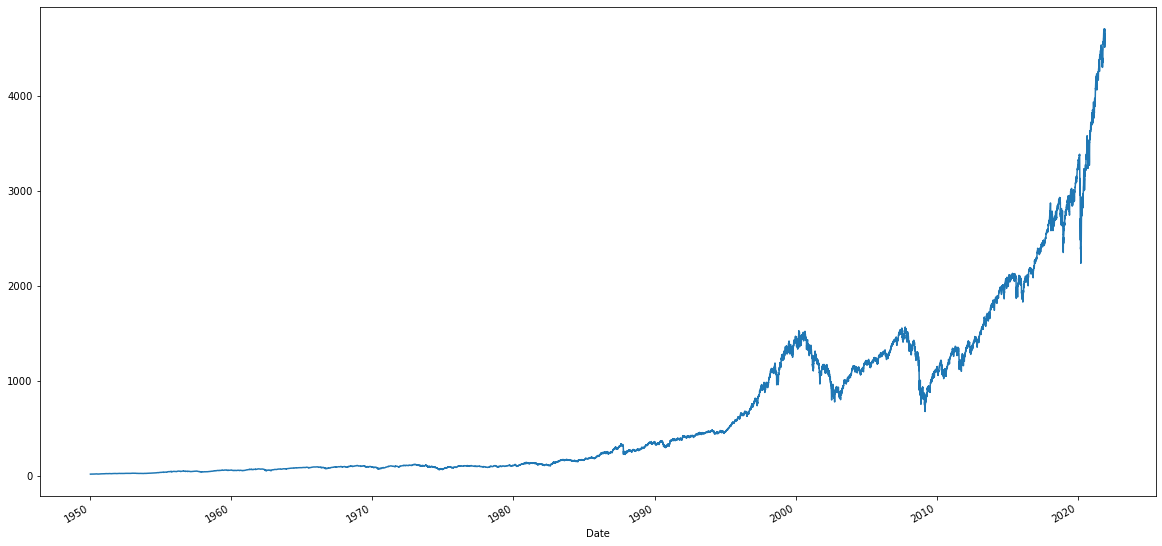

In [101]:
quote.set_index('Date')['Adj Close'].plot(figsize=(20,10))

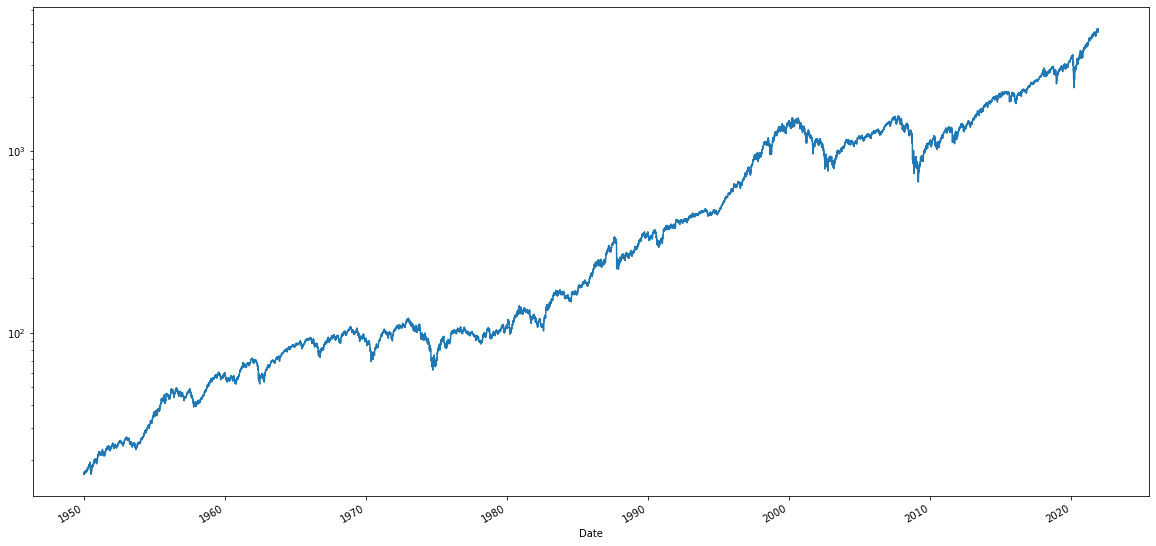

In [102]:
quote.set_index('Date')['Adj Close'].plot(figsize=(20,10)).set_yscale('log')

In [103]:
quote['Year'] = quote['Date'].map(lambda x:x.year)
quote

,Date,Open,High,Low,Close,Adj Close,Volume,Year
0,1950-01-03,16.660,16.660,16.660,16.660,16.660,1260000,1950
1,1950-01-04,16.850,16.850,16.850,16.850,16.850,1890000,1950
2,1950-01-05,16.930,16.930,16.930,16.930,16.930,2550000,1950
3,1950-01-06,16.980,16.980,16.980,16.980,16.980,2010000,1950
4,1950-01-09,17.080,17.080,17.080,17.080,17.080,2520000,1950
...,...,...,...,...,...,...,...,...
18097,2021-12-02,"4,504.730","4,595.460","4,504.730","4,577.100","4,577.100",3771510000,2021
18098,2021-12-03,"4,589.490","4,608.030","4,495.120","4,538.430","4,538.430",3971500000,2021
18099,2021-12-06,"4,548.370","4,612.600","4,540.510","4,591.670","4,591.670",3305690000,2021
18100,2021-12-07,"4,631.970","4,694.040","4,631.970","4,686.750","4,686.750",3334320000,2021


In [104]:
last_close = float(quote.tail(1)['Adj Close'])
last_close

4701.209961

# We are trying to simulate the following scenario:
1. Someone want to invest 10000 each year<br>
1. He is trying to find which day to invest that 10000<br>
1. We'll see that the whether the timing plays a big role
***


In [105]:
def find_purchase_price(quote):
   
    aggregation =  {
        'Adj Close':  [
                       'max',  # Worst case, always to purchase at that year's highest point
                       'min',  # Best case, always to purchase at that year's lowest point
                       'mean', # Purchase at average point
                       np.random.choice # Doesn't care, random pick a day to invest
                      ]
        }
    
    
    every_year = quote.groupby('Year').agg(aggregation)
    every_year.columns = every_year.columns.get_level_values(1)
    every_year.reset_index()
    # the renaming in aggregation dict is deprecated, explicitly rename here:
    every_year.columns = ['Max', 'Min', 'Avg', 'Rand']
    return every_year

every_year = find_purchase_price(quote)
every_year

,Max,Min,Avg,Rand
Year,,,,
1950,20.430,16.660,18.397,18.690
1951,23.850,20.690,22.322,21.760
1952,26.590,23.090,24.496,23.800
1953,26.660,22.710,24.723,26.420
1954,35.980,24.800,29.724,32.400
...,...,...,...,...
2017,"2,690.160","2,257.830","2,449.076","2,582.140"
2018,"2,930.750","2,351.100","2,746.214","2,904.980"
2019,"3,240.020","2,447.890","2,913.356","2,596.640"


In [106]:
def invest(amount, purchase_pricing):
    purchase_pricing["MaxShare"] = amount/purchase_pricing['Max']
    purchase_pricing['MinShare'] = amount/purchase_pricing['Min']
    purchase_pricing['AvgShare'] = amount/purchase_pricing['Avg']
    purchase_pricing['RandShare'] = amount/purchase_pricing['Rand']
    return purchase_pricing

every_year_investment = 12000.0
every_year = invest(every_year_investment, every_year)
every_year

,Max,Min,Avg,Rand,MaxShare,MinShare,AvgShare,RandShare
Year,,,,,,,,
1950,20.430,16.660,18.397,18.690,587.372,720.288,652.271,642.055
1951,23.850,20.690,22.322,21.760,503.145,579.990,537.589,551.471
1952,26.590,23.090,24.496,23.800,451.297,519.706,489.873,504.202
1953,26.660,22.710,24.723,26.420,450.113,528.402,485.386,454.201
1954,35.980,24.800,29.724,32.400,333.519,483.871,403.713,370.370
...,...,...,...,...,...,...,...,...
2017,"2,690.160","2,257.830","2,449.076","2,582.140",4.461,5.315,4.900,4.647
2018,"2,930.750","2,351.100","2,746.214","2,904.980",4.095,5.104,4.370,4.131
2019,"3,240.020","2,447.890","2,913.356","2,596.640",3.704,4.902,4.119,4.621


In [110]:
def get_irr(final_value):
    return npf.irr(np.append(np.full(len(every_year), -every_year_investment),final_value))*100

def get_result(every_year):
    today = every_year.sum()

    max_value = today['MaxShare']*last_close
    min_value = today['MinShare']*last_close
    avg_value = today['AvgShare']*last_close
    rand_value = today['RandShare']*last_close

    print ("Buy On Highest Day: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(max_value, get_irr(max_value)))
    print ("Buy On Lowest Day: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(min_value, get_irr(min_value)))
    print ("Buy On Average Day: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(avg_value, get_irr(avg_value)))
    print ("Buy On Random Day: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(rand_value, get_irr(rand_value)))

get_result(every_year)

Buy On Highest Day: $33,040,474.13, Interal Return Rate:7.60%
Buy On Lowest Day: $41,068,873.63, Interal Return Rate:8.00%
Buy On Average Day: $36,474,219.97, Interal Return Rate:7.78%
Buy On Random Day: $36,061,953.35, Interal Return Rate:7.76%


In [113]:
print ("No investment:  ${0:12,.2f}".format(len(every_year)*every_year_investment))
print ("3% interest CD: ${0:12,.2f}".format(npf.fv(0.03, len(every_year), -every_year_investment, 0)))


No investment:  $  864,000.00
3% interest CD: $2,960,006.91


# "Monkey Investor" 
## We can see that invest on a random day gives you almost average result
### As long as you invest and hold, the day doesn't matter.  You should beat all the bank saving account and *most of investors*.

In [129]:
#let play the random choice multiple times to get the feeling
try_again = find_purchase_price(quote)
invest(every_year_investment, try_again)
get_result(try_again)

Buy On Highest Day: $33,040,474.13, Interal Return Rate:7.60%
Buy On Lowest Day: $41,068,873.63, Interal Return Rate:8.00%
Buy On Average Day: $36,474,219.97, Interal Return Rate:7.78%
Buy On Random Day: $36,740,170.53, Interal Return Rate:7.80%


In [130]:
# https://www.dividend.com/dividend-stocks/uncategorized/other/spy-spdr-sandp-500/
# median dividen is 1.75%, we use 1% to simulate the tax burdens
def calc_dividend(row):
    return row["RandShare"]*1.01**(2021-int(row.name))

def add_dividend(every_year):
    every_year["RandShareWithDividend"] = every_year.apply(calc_dividend, axis=1)
    
add_dividend(try_again)

In [131]:
pd.options.display.min_rows = 10
pd.options.display.max_rows = 10
try_again

,Max,Min,Avg,Rand,MaxShare,MinShare,AvgShare,RandShare,RandShareWithDividend
Year,,,,,,,,,
1950,20.430,16.660,18.397,17.560,587.372,720.288,652.271,683.371,"1,385.078"
1951,23.850,20.690,22.322,21.610,503.145,579.990,537.589,555.298,"1,114.353"
1952,26.590,23.090,24.496,23.600,451.297,519.706,489.873,508.475,"1,010.285"
1953,26.660,22.710,24.723,24.660,450.113,528.402,485.386,486.618,957.286
1954,35.980,24.800,29.724,29.210,333.519,483.871,403.713,410.818,800.169
...,...,...,...,...,...,...,...,...,...
2017,"2,690.160","2,257.830","2,449.076","2,365.450",4.461,5.315,4.900,5.073,5.279
2018,"2,930.750","2,351.100","2,746.214","2,467.700",4.095,5.104,4.370,4.863,5.010
2019,"3,240.020","2,447.890","2,913.356","2,884.050",3.704,4.902,4.119,4.161,4.244


# The dividend matters! Re-invest your dividend

In [132]:
long_term_captial_gain_tax=0.15
def get_value_with_dividend(every_year, message = 'Buy On Random Day with dividend:'):
    today_with_dividend = every_year.sum()
    rand_value_with_dividen = today_with_dividend['RandShareWithDividend']*last_close*(1-long_term_captial_gain_tax)
    print (message + " ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(rand_value_with_dividen, get_irr(rand_value_with_dividen)))

get_value_with_dividend(try_again)

Buy On Random Day with dividend: $55,587,882.15, Interal Return Rate:8.54%


# Time, Not Timing, Is What Matters

In [134]:
def invest_with_dividend():
    data = find_purchase_price(quote)
    invest(every_year_investment, data)
    add_dividend(data)
    return data

onlyInvestTop20Years = invest_with_dividend()
column_index = onlyInvestTop20Years.columns.get_loc("RandShareWithDividend")
onlyInvestTop20Years.iloc[20:, column_index] = 0
get_value_with_dividend(onlyInvestTop20Years, 'Only invest top 20 years')
#display(onlyInvestTop20Years)

onlyInvestLast50Years = invest_with_dividend()
onlyInvestLast50Years.iloc[:20, column_index] = 0
get_value_with_dividend(onlyInvestLast50Years, 'Only invest last 51 years')
#display(onlyInvestLast50Years)

Only invest top 20 years $40,888,083.51, Interal Return Rate:7.99%
Only invest last 51 years $14,012,206.27, Interal Return Rate:6.02%


# Let's try floor and caps

In [137]:
quote['YearMonth'] = quote['Date'].map(lambda x: f"{x.year}-{str(x.month).zfill(2)}")

def calc_monthly_change(quote):
    first_day_of_each_month = quote.groupby('YearMonth')['Adj Close'].agg(['first'])
    first_day_of_each_month["change"] = first_day_of_each_month.pct_change(12)
    return first_day_of_each_month

first_day_of_each_month = calc_monthly_change(quote)
pd.options.display.min_rows = 50
pd.options.display.max_rows = 50
first_day_of_each_month

,first,change
YearMonth,,
1950-01,16.660,nan
1950-02,17.050,nan
1950-03,17.240,nan
1950-04,17.530,nan
1950-05,18.220,nan
1950-06,18.770,nan
1950-07,17.640,nan
1950-08,18.020,nan
1950-09,18.550,nan


In [173]:
def simulate_iul(change):
    if change < 0:
        return 0
    if change > 0.135:
        return 0.135
    return change

first_day_of_each_month = calc_monthly_change(quote)
first_day_of_each_month["iul_mode"] = first_day_of_each_month['change'].apply(simulate_iul)
#pd.set_option("display.max_rows", 36)
display(first_day_of_each_month)

,first,change,iul_mode
YearMonth,,,
1950-01,16.660,nan,nan
1950-02,17.050,nan,nan
1950-03,17.240,nan,nan
1950-04,17.530,nan,nan
1950-05,18.220,nan,nan
1950-06,18.770,nan,nan
1950-07,17.640,nan,nan
1950-08,18.020,nan,nan
1950-09,18.550,nan,nan


In [171]:
import copy
first_day_of_each_month["cash_value"] = every_year_investment/12*0.75 #assuming 25% cost of insurance (COI)
iul_invest = first_day_of_each_month.copy()

#Index Account Monthly Charge
IAMC_rate = 0.0072

def calc_compond_cash_value(df):
    for i in range(12, len(df)):
        df.loc[df.index[i], "cash_value"] = (1 + df.iloc[i]['iul_mode'])*df.iloc[i-12]['cash_value'] +  df.iloc[i]["cash_value"]*(1-IAMC_rate) 

calc_compond_cash_value(iul_invest)

iul_invest

,first,change,iul_mode,cash_value
YearMonth,,,,
1950-01,16.660,nan,nan,750.000
1950-02,17.050,nan,nan,750.000
1950-03,17.240,nan,nan,750.000
1950-04,17.530,nan,nan,750.000
1950-05,18.220,nan,nan,750.000
1950-06,18.770,nan,nan,750.000
1950-07,17.640,nan,nan,750.000
1950-08,18.020,nan,nan,750.000
1950-09,18.550,nan,nan,750.000


In [172]:
final_value = iul_invest.tail(12).sum()["cash_value"]
investment_table = np.append(np.full(len(every_year), -every_year_investment),final_value)
iul_irr = npf.irr(investment_table)*100
print ("IUL mode: ${0:12,.2f}, Interal Return Rate:{1:.2f}%".format(final_value, iul_irr))

IUL mode: $25,935,378.69, Interal Return Rate:7.16%
